# Subspace learning experiments

Test recurrent gain control as a whitening op for online PCA with/without local whitening.

In [1]:
import itertools
import os
import multiprocessing
from typing import Optional
print(f'cpus: {multiprocessing.cpu_count()}')

# set to OMP_NUM_THREADS=1 to avoid multithreading oversubscription
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy as sp
import seaborn as sns
from tqdm import tqdm

cpus: 128


In [2]:
def get_conv_frame(n: int, m: int, h: int, w: int) -> npt.NDArray[np.float64]:
    """Returns a specific convolutional frame that connects all pairs within a window.

    Assumes the nxm image is vectorized, and the filter/neighbourhood size is hxw.

    Parameters
    ----------
    n: Height of image.
    m: Width of image.
    h: Height of convolutional filter.
    w: Width of convolutional filter.

    Returns
    -------
    W: Convolutional frame.
    """
    assert n >= 1 and m >= 1
    assert n >= h and m >= w


    nm = n * m
    # hw = h * w
    
    # singly-connected interneurons
    WI = np.eye(nm)
    
    # doubly-connected (paired) interneurons
    idx_set = set()
    WP = []
    normalize = lambda x: x / np.linalg.norm(x)

    all_indices = list(itertools.product(range(n), range(m)))
    for i, j in all_indices:
        for k, l in all_indices:

            # get flat indices
            ij_flat = np.ravel_multi_index((i, j), (n, m))
            kl_flat = np.ravel_multi_index((k, l), (n, m))
            if (
                (i, j) != (k, l) and
                (ij_flat, kl_flat) not in idx_set and
                (kl_flat, ij_flat) not in idx_set and
                np.abs(i - k) < h and
                np.abs(j - l) < w
            ):
                idx_set.add((ij_flat, kl_flat))
                # pair (i, j) and (k, l) via flattened indices, and normalize
                wp = np.zeros(nm)
                wp[ij_flat] = 1
                wp[kl_flat] = 1
                WP.append(normalize(wp))

    WP = np.stack(WP, 0)
    
    W = np.concatenate([WI, WP], 0).T
    return W


## Data

This Css is derived from image patches drawn from a region in a natural image.

[Text(0.5, 1.0, 'cov')]

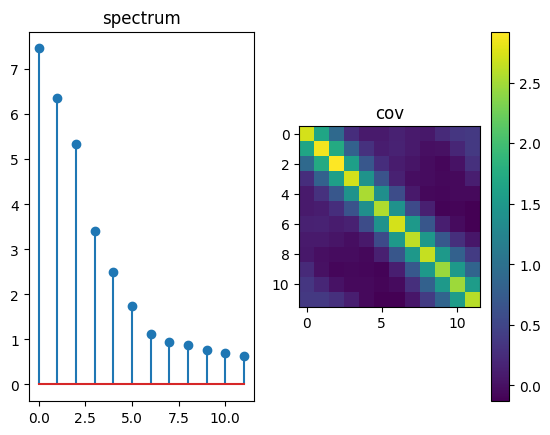

In [3]:
Css = np.array([[ 2.72503556e-03,  1.66159109e-03,  9.09272723e-04,
         2.66247738e-04,  9.31352443e-05,  8.43885225e-05,
         1.45249217e-04,  8.68591686e-05,  7.03666403e-05,
         2.36188196e-04,  3.54822018e-04,  3.80442455e-04],
       [ 1.66159109e-03,  2.86647170e-03,  1.73230638e-03,
         8.22416147e-04,  3.04907668e-04,  1.17087328e-04,
         1.65404890e-04,  8.69869962e-05, -1.04023498e-05,
         4.06856537e-06,  2.02270055e-04,  3.71472451e-04],
       [ 9.09272723e-04,  1.73230638e-03,  2.92233438e-03,
         1.59358444e-03,  6.98926401e-04,  2.67397956e-04,
         1.05786740e-04,  4.15509392e-05, -2.52410062e-05,
        -7.80714568e-05,  1.86188029e-05,  2.94864577e-04],
       [ 2.66247738e-04,  8.22416147e-04,  1.59358444e-03,
         2.71091487e-03,  1.43292864e-03,  6.53174004e-04,
         1.45567135e-04, -2.24374888e-05, -2.89584743e-05,
        -6.36836427e-05, -5.02806319e-05,  1.22041099e-04],
       [ 9.31352443e-05,  3.04907668e-04,  6.98926401e-04,
         1.43292864e-03,  2.53818099e-03,  1.39415755e-03,
         5.76428701e-04,  8.09043519e-05, -6.48001179e-05,
        -7.36216171e-05, -4.74706064e-05, -5.90117140e-05],
       [ 8.43885225e-05,  1.17087328e-04,  2.67397956e-04,
         6.53174004e-04,  1.39415755e-03,  2.56166077e-03,
         1.42768852e-03,  5.49699590e-04,  1.41706942e-04,
        -9.98097377e-05, -9.28916753e-05, -1.30619483e-04],
       [ 1.45249217e-04,  1.65404890e-04,  1.05786740e-04,
         1.45567135e-04,  5.76428701e-04,  1.42768852e-03,
         2.72958966e-03,  1.51385198e-03,  6.82686722e-04,
         1.20612918e-04, -3.78548836e-05, -1.27079765e-04],
       [ 8.68591686e-05,  8.69869962e-05,  4.15509392e-05,
        -2.24374888e-05,  8.09043519e-05,  5.49699590e-04,
         1.51385198e-03,  2.61636919e-03,  1.49368019e-03,
         7.08752187e-04,  2.79948961e-04,  4.95579453e-05],
       [ 7.03666403e-05, -1.04023498e-05, -2.52410062e-05,
        -2.89584743e-05, -6.48001179e-05,  1.41706942e-04,
         6.82686722e-04,  1.49368019e-03,  2.64888457e-03,
         1.50652638e-03,  8.14155040e-04,  4.02700589e-04],
       [ 2.36188196e-04,  4.06856537e-06, -7.80714568e-05,
        -6.36836427e-05, -7.36216171e-05, -9.98097377e-05,
         1.20612918e-04,  7.08752187e-04,  1.50652638e-03,
         2.46573628e-03,  1.50893197e-03,  8.56130707e-04],
       [ 3.54822018e-04,  2.02270055e-04,  1.86188029e-05,
        -5.02806319e-05, -4.74706064e-05, -9.28916753e-05,
        -3.78548836e-05,  2.79948961e-04,  8.14155040e-04,
         1.50893197e-03,  2.47427529e-03,  1.56061374e-03],
       [ 3.80442455e-04,  3.71472451e-04,  2.94864577e-04,
         1.22041099e-04, -5.90117140e-05, -1.30619483e-04,
        -1.27079765e-04,  4.95579453e-05,  4.02700589e-04,
         8.56130707e-04,  1.56061374e-03,  2.59721762e-03]])

fig, ax = plt.subplots(1, 2)
Css = Css * 1000
ax[0].stem(np.linalg.svd(Css)[1])
im = ax[1].imshow(Css)
plt.colorbar(im)
ax[0].set(title=f'spectrum' )
ax[1].set(title=f'cov' )

In [100]:
def compute_subspace_error(V: npt.NDArray[np.float64], V0: npt.NDArray[np.float64]) -> float:
    """Compute principal angles."""
    angles = sp.linalg.subspace_angles(V, V0)
    return np.mean(angles)


def subspace_learning_offline(
    Css: npt.NDArray[np.float64],
    x_dim: int, 
    step_oja: float, 
    relative_speed: float, 
    iters: int = 100_000,
    method: str = 'direct',
    seed: Optional[int] = None,
    neighborhood_size: int = 1,
    frame_type: str = 'full',
    ) -> npt.NDArray[np.float64]:
    """Subspace learning experiment for a given Css."""
    assert method in ['direct', 'weights', 'gain_ctrl']
    assert frame_type in ['full', 'conv']

    rng = np.random.default_rng(seed)
    step_size = relative_speed * step_oja

    # ground truth principal subspace
    s_dim = Css.shape[0]
    # Lss = np.linalg.cholesky(Css)

    _, _, Vh = np.linalg.svd(Css, full_matrices=False, compute_uv=True)
    V0 = Vh.T
    V0 = V0[:, :x_dim]  # top x_dim eigenvectors

    # init weights from s to x
    V = rng.standard_normal((x_dim, s_dim))

    # init M
    Q = sp.stats.ortho_group.rvs(x_dim, random_state=rng)
    P = sp.stats.ortho_group.rvs(x_dim+1, random_state=rng)[:,:x_dim]
    W0 = Q@np.diag(rng.uniform(1, 1.5, (x_dim,)))**2 @P.T
    M = W0@W0.T

    if frame_type == 'full':
        KN = x_dim * (x_dim + 1) // 2
        W = rng.standard_normal((x_dim, KN))
    else:
        W = get_conv_frame(x_dim, 1, neighborhood_size, 1)
        W = W.astype(np.float64)
    K = W.shape[1]
    W = W / np.linalg.norm(W, axis=0)

    err_subspace = []
    err_var = []
    In = np.eye(x_dim)
    g = np.ones(K)
    for _ in range(iters):
        err_subspace.append(compute_subspace_error(V.T, V0))

        if method == 'gain_ctrl':
            WGW = W @ (g[:, None] * W.T)  # equiv to W@diag(g)@W.T
            M_inv = np.linalg.inv(In + WGW)
            Cxx = V @ Css @ V.T
            # compute diag(W.T@Cyy@W) efficiently
            Cyy = M_inv @ Cxx @ M_inv.T
            tmp = Cyy @ W
            variances = np.array([w @ t for w, t in zip(W.T, tmp.T)])
            dg = variances - 1
            err_var.append(np.linalg.norm(dg))
            g = g + step_size * dg  # gradient ascent

        # dV = step_oja * (M_inv@V@Css - np.diag(np.diag(Cyy))@V)
        dV = step_oja * (M_inv@V@Css - (In*Cyy)@V)

        V = V + dV

    return err_subspace, err_var, Cyy

def simulate_many(
    step_oja: float,
    relative_speed: float,
    n_repeats: int, 
    method: str,
    neighborhood_size: int = 5,
    frame_type: str = 'full',
) -> npt.NDArray[np.float64]:
    """Run all simulations in parallel using multiprocessing."""
    x_dim = 8

    iters = int(1E5)
    Cyy = []
    all_errors_var = []

    with multiprocessing.Pool() as pool:
        all_errors_subspace = []
        pbar = tqdm(total=n_repeats)
        for results in pool.starmap(
            subspace_learning_offline, 
            [(Css, x_dim, step_oja, relative_speed, iters, method, i, neighborhood_size, frame_type) for i in range(n_repeats)]):
            errors_subspace, errors_var, cov_y = results
            all_errors_subspace.append(errors_subspace)
            all_errors_var.append(errors_var)
            pbar.update(1)
            Cyy.append(cov_y)
    all_errors_var = np.array(all_errors_var)
    all_errors_subspace = np.array(all_errors_subspace)
    Cyy = np.array(Cyy)
    sim_dict = {'errors_subspace': all_errors_subspace, 'errors_var': all_errors_var, 'Cyy': Cyy}
    return sim_dict

n_repeats = 10

relative_speed = 50.
step_oja_g = 5E-4
neighborhood_size = -1
sim_dict_full = simulate_many(
    step_oja_g,
    relative_speed, 
    n_repeats, 
    'gain_ctrl', 
    neighborhood_size, 
    frame_type='full'
    )

neighborhood_size = 3
sim_dict_conv = simulate_many(
    step_oja_g,
    relative_speed, 
    n_repeats, 
    'gain_ctrl', 
    neighborhood_size, 
    frame_type='conv'
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.13s/it]


## plot

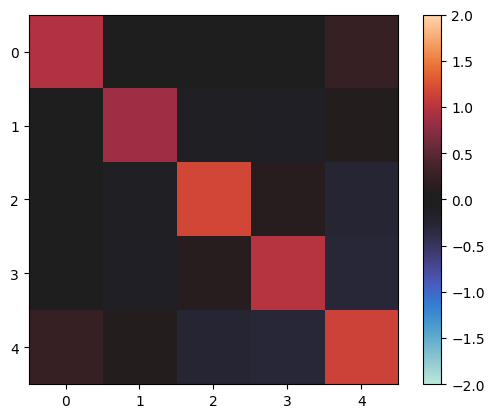

In [93]:
plt.imshow(sim_dict_full['Cyy'][0], cmap=sns.color_palette('icefire', as_cmap=True), vmin=-2, vmax=2)
plt.colorbar()

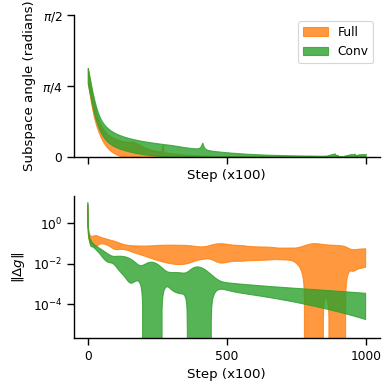

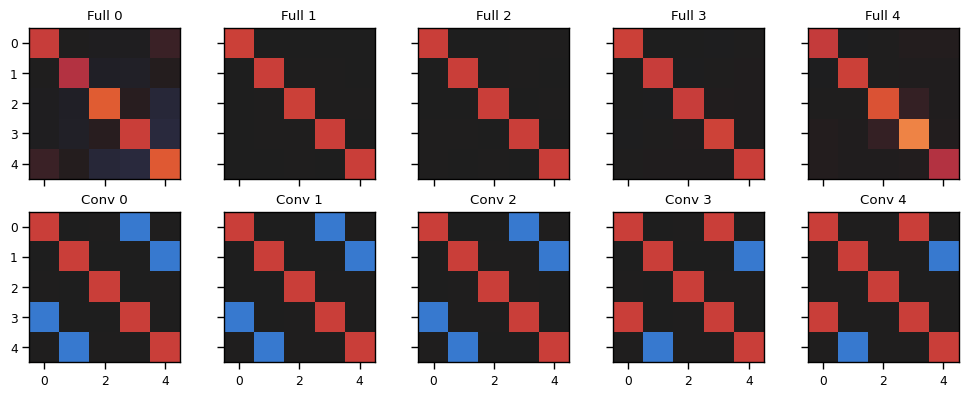

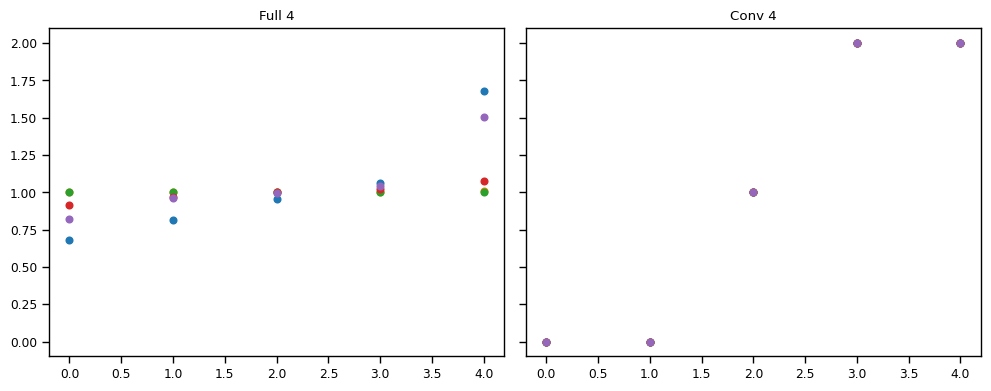

In [99]:
def plot_shaded_error(all_errors, ax, **kwargs):
    mu = np.mean(all_errors, axis=0)
    sigma = np.std(all_errors, axis=0)#np.sqrt(all_errors.shape[0])
    x = np.arange(len(mu))
    ax.fill_between(x, mu+sigma, np.clip(mu-sigma, 0, None), alpha=.8, **kwargs)


with sns.plotting_context('paper'):
    fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex='all', dpi=100)

    step_skip = 100

    plot_shaded_error(sim_dict_full['errors_subspace'][:, ::step_skip], ax[0], label='Full', color='C1')
    plot_shaded_error(sim_dict_conv['errors_subspace'][:, ::step_skip], ax[0], label='Conv', color='C2')
    ax[0].set(
        # title=r'$\eta=$'f'{relative_speed}''$\zeta$',
        ylabel='Subspace angle (radians)', 
        xlabel='Step (x100)', 
        xticks = (0, 500, 1000),
        ylim=(0, np.pi/2), 
        yticks=[0, np.pi/4, np.pi/2], 
        yticklabels=[0, r'$\pi/4$', r'$\pi/2$'],
        )
    
    ax[0].legend()

    plot_shaded_error(sim_dict_full['errors_var'][:, ::step_skip], ax[1], label='Full', color='C1')
    plot_shaded_error(sim_dict_conv['errors_var'][:, ::step_skip], ax[1], label='Conv', color='C2')
    ax[1].set(
        ylabel=r'$\Vert \Delta g \Vert$', 
        xlabel='Step (x100)', 
        xticks = (0, 500, 1000),
        yscale='log',
        )

    sns.despine()
    fig.tight_layout()


# plot all covs for full in top row and conv in bottom row
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(2, 5, figsize=(10, 4), sharex='all', sharey='all', dpi=100)
    # compute the vmax of both cov full and conv
    vmax = np.max(np.abs(np.concatenate([sim_dict_full['Cyy'], sim_dict_conv['Cyy']])))

    for i in range(5):
        ax[0, i].imshow(sim_dict_full['Cyy'][i], cmap=sns.color_palette('icefire', as_cmap=True), vmin=-vmax, vmax=vmax)
        ax[1, i].imshow(sim_dict_conv['Cyy'][i], cmap=sns.color_palette('icefire', as_cmap=True), vmin=-vmax, vmax=vmax)
        ax[0, i].set_title(f'Full {i}')
        ax[1, i].set_title(f'Conv {i}')

    fig.tight_layout()

# plot all the eigenspectra for full in top row and conv in bottom row
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex='all', sharey='all', dpi=100)

    for i in range(5):
        ax[0, ].plot(np.linalg.eigvalsh(sim_dict_full['Cyy'][i]), 'o')
        ax[1, ].plot(np.linalg.eigvalsh(sim_dict_conv['Cyy'][i]), 'o')
        ax[0, ].set_title(f'Full {i}')
        ax[1, ].set_title(f'Conv {i}')

    fig.tight_layout()